# Relational Knowledge Distillation - Wider Dataset

https://arxiv.org/abs/1904.05068

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import boto3
import io
import os

# new libraries
from models_package.models import Teacher, Student, CustomResNet18
from torchvision import datasets, transforms, models
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof, load_wider
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss, DD_loss, AD_loss, RKDDistanceLoss, RKDAngleLoss
from utils.misc_tools_rkd import best_lr_rkd, rkd_train_teacher, rkd_train_student_with_distillation
from utils.compare_tools_rkd import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison


In [6]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 240
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 30
step_size = 30
gamma = 0.1
beta = 0.0
patience = 7  # for early stopping

batch_size = 16
num_workers = 2

# class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
# class_labels_new = torch.tensor([i for i in range(len(class_labels))])

In [7]:
# Load WIDER dataset


train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])


trainloader, testloader  =  load_wider(train_file, test_file, class_labels, 
                                       batch_size, num_workers) 

Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [8]:
# # Accessing a single batch from the DataLoader
# batch = next(iter(trainloader))
# batch

In [9]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = models.resnet50(pretrained=True)  # Keep ResNet50 as it is
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = CustomResNet18()

In [10]:
# Ensure the final classification layer is added to the model
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, num_classes)
student_model.fc = nn.Linear(student_model.output_size, num_classes)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)


criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [11]:
torch.cuda.empty_cache()

In [8]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [9]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"


## Fina the best learning rate

In [ ]:
studnet_lr = best_lr_rkd(teacher_model, trainloader, criterion, 
                        teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
print(studnet_lr)

100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:27<00:00,  5.11it/s]


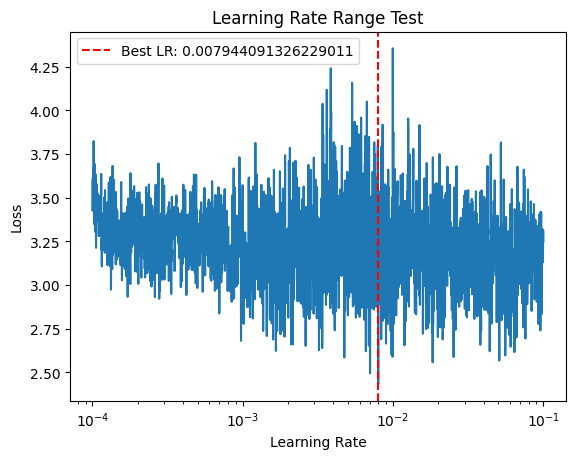

Best learning rate: 0.007944091326229011
0.007944091326229011


In [9]:
studnet_lr = best_lr_rkd(student_model, trainloader, criterion, 
                         student_optimizer, student_scheduler, device, num_epochs=3)  
print(studnet_lr)

In [12]:
teacher_lr = 0.09999999999999999
student_lr = 0.007944091326229011

In [13]:
# Ensure the final classification layer is added to the model
# num_class = 30
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, num_classes)
student_model.fc = nn.Linear(student_model.output_size, num_classes)

# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=student_lr, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=teacher_lr, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Training Teacher and Student Models

In [14]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [15]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
rkd_train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)


100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:29<00:00,  5.03it/s]


*****Epoch 1/240*****
*****Train Loss:  3.428959 Val Loss:  3.309714*****
*****Validation Accuracy: 6.59%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:30<00:00,  5.01it/s]


*****Epoch 2/240*****
*****Train Loss:  3.311750 Val Loss:  3.309647*****
*****Validation Accuracy: 7.81%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:29<00:00,  5.03it/s]


*****Epoch 3/240*****
*****Train Loss:  3.310989 Val Loss:  3.307490*****
*****Validation Accuracy: 9.32%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:26<00:00,  5.13it/s]


*****Epoch 4/240*****
*****Train Loss:  3.309606 Val Loss:  3.316704*****
*****Validation Accuracy: 9.32%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:28<00:00,  5.07it/s]


*****Epoch 5/240*****
*****Train Loss:  3.311579 Val Loss:  3.308710*****
*****Validation Accuracy: 9.32%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:28<00:00,  5.07it/s]


*****Epoch 6/240*****
*****Train Loss:  3.311465 Val Loss:  3.305447*****
*****Validation Accuracy: 9.32%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:29<00:00,  5.05it/s]


*****Epoch 7/240*****
*****Train Loss:  3.312504 Val Loss:  3.306775*****
*****Validation Accuracy: 9.32%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:27<00:00,  5.12it/s]


*****Epoch 8/240*****
*****Train Loss:  3.311934 Val Loss:  3.308801*****
*****Validation Accuracy: 7.81%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:27<00:00,  5.12it/s]

*****Epoch 9/240*****
*****Train Loss:  3.310903 Val Loss:  3.304774*****
*****Validation Accuracy: 9.32%*****

Early stopping
Finished Training Teacher


In [16]:
torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_wider.pth')
torch.save(teacher_model, 'teacher_model_rkd_wider.pth')
print('teacher weights and architecture saved and exported')

teacher weights and architecture saved and exported


In [17]:
# Call the function to train the student model with knowledge distillation
rkd_train_student_with_distillation(student_model, teacher_model, trainloader, criterion,
                                    student_optimizer, student_scheduler, device, alpha, 
                                    temperature, num_epochs=num_epochs)

100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.26it/s]


*****Epoch 1/240*****
*****Train Loss:  3.476309 Val Loss:  3.229463*****
*****Validation Accuracy: 15.64%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.27it/s]


*****Epoch 2/240*****
*****Train Loss:  3.286153 Val Loss:  3.115139*****
*****Validation Accuracy: 15.95%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.19it/s]


*****Epoch 3/240*****
*****Train Loss:  3.247914 Val Loss:  3.079936*****
*****Validation Accuracy: 18.49%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:29<00:00,  5.03it/s]


*****Epoch 4/240*****
*****Train Loss:  3.219821 Val Loss:  3.105066*****
*****Validation Accuracy: 16.88%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.18it/s]


*****Epoch 5/240*****
*****Train Loss:  3.197665 Val Loss:  3.020034*****
*****Validation Accuracy: 18.76%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.25it/s]


*****Epoch 6/240*****
*****Train Loss:  3.175266 Val Loss:  2.970079*****
*****Validation Accuracy: 20.48%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.21it/s]


*****Epoch 7/240*****
*****Train Loss:  3.145708 Val Loss:  2.942017*****
*****Validation Accuracy: 19.49%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.17it/s]


*****Epoch 8/240*****
*****Train Loss:  3.133631 Val Loss:  2.928577*****
*****Validation Accuracy: 21.23%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.22it/s]


*****Epoch 9/240*****
*****Train Loss:  3.108287 Val Loss:  2.867380*****
*****Validation Accuracy: 24.09%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.27it/s]


*****Epoch 10/240*****
*****Train Loss:  3.098506 Val Loss:  2.848629*****
*****Validation Accuracy: 23.73%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:22<00:00,  5.27it/s]


*****Epoch 11/240*****
*****Train Loss:  3.071307 Val Loss:  2.822035*****
*****Validation Accuracy: 23.90%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.19it/s]


*****Epoch 12/240*****
*****Train Loss:  3.059771 Val Loss:  2.843442*****
*****Validation Accuracy: 23.96%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:26<00:00,  5.16it/s]


*****Epoch 13/240*****
*****Train Loss:  3.032064 Val Loss:  2.726762*****
*****Validation Accuracy: 27.08%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.22it/s]


*****Epoch 14/240*****
*****Train Loss:  3.011847 Val Loss:  2.699879*****
*****Validation Accuracy: 27.15%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:26<00:00,  5.16it/s]


*****Epoch 15/240*****
*****Train Loss:  2.993802 Val Loss:  2.658444*****
*****Validation Accuracy: 28.26%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.20it/s]


*****Epoch 16/240*****
*****Train Loss:  2.969773 Val Loss:  2.707333*****
*****Validation Accuracy: 27.02%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.26it/s]


*****Epoch 17/240*****
*****Train Loss:  2.954466 Val Loss:  2.582439*****
*****Validation Accuracy: 32.24%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.22it/s]


*****Epoch 18/240*****
*****Train Loss:  2.928295 Val Loss:  2.587297*****
*****Validation Accuracy: 29.80%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:27<00:00,  5.13it/s]


*****Epoch 19/240*****
*****Train Loss:  2.904940 Val Loss:  2.515080*****
*****Validation Accuracy: 31.97%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:29<00:00,  5.04it/s]


*****Epoch 20/240*****
*****Train Loss:  2.876591 Val Loss:  2.466506*****
*****Validation Accuracy: 36.06%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:26<00:00,  5.14it/s]


*****Epoch 21/240*****
*****Train Loss:  2.855141 Val Loss:  2.442999*****
*****Validation Accuracy: 35.36%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.24it/s]


*****Epoch 22/240*****
*****Train Loss:  2.836803 Val Loss:  2.512347*****
*****Validation Accuracy: 32.70%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.27it/s]


*****Epoch 23/240*****
*****Train Loss:  2.812224 Val Loss:  2.393155*****
*****Validation Accuracy: 36.15%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:26<00:00,  5.13it/s]


*****Epoch 24/240*****
*****Train Loss:  2.790071 Val Loss:  2.360378*****
*****Validation Accuracy: 37.12%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.25it/s]


*****Epoch 25/240*****
*****Train Loss:  2.763588 Val Loss:  2.356203*****
*****Validation Accuracy: 36.84%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:26<00:00,  5.14it/s]


*****Epoch 26/240*****
*****Train Loss:  2.733635 Val Loss:  2.276160*****
*****Validation Accuracy: 38.90%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:21<00:00,  5.31it/s]


*****Epoch 27/240*****
*****Train Loss:  2.698608 Val Loss:  2.304792*****
*****Validation Accuracy: 37.33%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.19it/s]


*****Epoch 28/240*****
*****Train Loss:  2.671125 Val Loss:  2.131243*****
*****Validation Accuracy: 43.56%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.26it/s]


*****Epoch 29/240*****
*****Train Loss:  2.644399 Val Loss:  2.169450*****
*****Validation Accuracy: 42.15%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.20it/s]


*****Epoch 30/240*****
*****Train Loss:  2.603953 Val Loss:  2.154076*****
*****Validation Accuracy: 42.46%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.26it/s]


*****Epoch 31/240*****
*****Train Loss:  2.412814 Val Loss:  1.862332*****
*****Validation Accuracy: 51.63%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.26it/s]


*****Epoch 32/240*****
*****Train Loss:  2.358620 Val Loss:  1.823891*****
*****Validation Accuracy: 53.30%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.21it/s]


*****Epoch 33/240*****
*****Train Loss:  2.336402 Val Loss:  1.776170*****
*****Validation Accuracy: 53.23%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.17it/s]


*****Epoch 34/240*****
*****Train Loss:  2.299629 Val Loss:  1.732094*****
*****Validation Accuracy: 54.51%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:22<00:00,  5.31it/s]


*****Epoch 35/240*****
*****Train Loss:  2.277980 Val Loss:  1.713772*****
*****Validation Accuracy: 55.04%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:26<00:00,  5.14it/s]


*****Epoch 36/240*****
*****Train Loss:  2.264718 Val Loss:  1.670752*****
*****Validation Accuracy: 56.68%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:22<00:00,  5.27it/s]


*****Epoch 37/240*****
*****Train Loss:  2.242588 Val Loss:  1.644999*****
*****Validation Accuracy: 57.63%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.25it/s]


*****Epoch 38/240*****
*****Train Loss:  2.222033 Val Loss:  1.647619*****
*****Validation Accuracy: 58.19%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.24it/s]


*****Epoch 39/240*****
*****Train Loss:  2.212896 Val Loss:  1.605454*****
*****Validation Accuracy: 59.14%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.19it/s]


*****Epoch 40/240*****
*****Train Loss:  2.186860 Val Loss:  1.574426*****
*****Validation Accuracy: 59.90%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.27it/s]


*****Epoch 41/240*****
*****Train Loss:  2.172620 Val Loss:  1.550571*****
*****Validation Accuracy: 60.37%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.24it/s]


*****Epoch 42/240*****
*****Train Loss:  2.155904 Val Loss:  1.498964*****
*****Validation Accuracy: 62.27%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.20it/s]


*****Epoch 43/240*****
*****Train Loss:  2.122235 Val Loss:  1.467004*****
*****Validation Accuracy: 63.49%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.21it/s]


*****Epoch 44/240*****
*****Train Loss:  2.104947 Val Loss:  1.428749*****
*****Validation Accuracy: 63.66%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.20it/s]


*****Epoch 45/240*****
*****Train Loss:  2.090045 Val Loss:  1.435757*****
*****Validation Accuracy: 64.94%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:26<00:00,  5.15it/s]


*****Epoch 46/240*****
*****Train Loss:  2.062849 Val Loss:  1.378183*****
*****Validation Accuracy: 66.19%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.24it/s]


*****Epoch 47/240*****
*****Train Loss:  2.046744 Val Loss:  1.361100*****
*****Validation Accuracy: 66.58%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:26<00:00,  5.15it/s]


*****Epoch 48/240*****
*****Train Loss:  2.022080 Val Loss:  1.327565*****
*****Validation Accuracy: 68.31%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.21it/s]


*****Epoch 49/240*****
*****Train Loss:  1.998889 Val Loss:  1.306707*****
*****Validation Accuracy: 67.88%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.20it/s]


*****Epoch 50/240*****
*****Train Loss:  1.970193 Val Loss:  1.218744*****
*****Validation Accuracy: 70.11%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:22<00:00,  5.30it/s]


*****Epoch 51/240*****
*****Train Loss:  1.935347 Val Loss:  1.216727*****
*****Validation Accuracy: 71.15%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.19it/s]


*****Epoch 52/240*****
*****Train Loss:  1.921571 Val Loss:  1.213535*****
*****Validation Accuracy: 70.63%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.25it/s]


*****Epoch 53/240*****
*****Train Loss:  1.897199 Val Loss:  1.128848*****
*****Validation Accuracy: 73.57%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:27<00:00,  5.12it/s]


*****Epoch 54/240*****
*****Train Loss:  1.875698 Val Loss:  1.098758*****
*****Validation Accuracy: 74.02%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.20it/s]


*****Epoch 55/240*****
*****Train Loss:  1.854015 Val Loss:  1.063578*****
*****Validation Accuracy: 75.10%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.18it/s]


*****Epoch 56/240*****
*****Train Loss:  1.837264 Val Loss:  1.049830*****
*****Validation Accuracy: 76.23%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.27it/s]


*****Epoch 57/240*****
*****Train Loss:  1.802267 Val Loss:  1.059279*****
*****Validation Accuracy: 77.99%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:28<00:00,  5.07it/s]


*****Epoch 58/240*****
*****Train Loss:  1.776687 Val Loss:  0.980232*****
*****Validation Accuracy: 78.09%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.18it/s]


*****Epoch 59/240*****
*****Train Loss:  1.767551 Val Loss:  0.930906*****
*****Validation Accuracy: 79.56%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.19it/s]


*****Epoch 60/240*****
*****Train Loss:  1.718930 Val Loss:  0.956002*****
*****Validation Accuracy: 80.45%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.26it/s]


*****Epoch 61/240*****
*****Train Loss:  1.625195 Val Loss:  0.843884*****
*****Validation Accuracy: 83.26%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:21<00:00,  5.34it/s]


*****Epoch 62/240*****
*****Train Loss:  1.597288 Val Loss:  0.824227*****
*****Validation Accuracy: 83.81%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.27it/s]


*****Epoch 63/240*****
*****Train Loss:  1.588797 Val Loss:  0.808774*****
*****Validation Accuracy: 84.38%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:26<00:00,  5.13it/s]


*****Epoch 64/240*****
*****Train Loss:  1.590141 Val Loss:  0.788459*****
*****Validation Accuracy: 84.54%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.18it/s]


*****Epoch 65/240*****
*****Train Loss:  1.573642 Val Loss:  0.789344*****
*****Validation Accuracy: 84.41%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.24it/s]


*****Epoch 66/240*****
*****Train Loss:  1.570463 Val Loss:  0.785986*****
*****Validation Accuracy: 84.86%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.17it/s]


*****Epoch 67/240*****
*****Train Loss:  1.575265 Val Loss:  0.779175*****
*****Validation Accuracy: 85.00%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:27<00:00,  5.11it/s]


*****Epoch 68/240*****
*****Train Loss:  1.564464 Val Loss:  0.766445*****
*****Validation Accuracy: 85.72%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.18it/s]


*****Epoch 69/240*****
*****Train Loss:  1.557442 Val Loss:  0.763615*****
*****Validation Accuracy: 85.01%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:28<00:00,  5.07it/s]


*****Epoch 70/240*****
*****Train Loss:  1.565168 Val Loss:  0.762241*****
*****Validation Accuracy: 85.81%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:26<00:00,  5.16it/s]


*****Epoch 71/240*****
*****Train Loss:  1.546707 Val Loss:  0.749965*****
*****Validation Accuracy: 86.09%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:26<00:00,  5.16it/s]


*****Epoch 72/240*****
*****Train Loss:  1.547525 Val Loss:  0.756599*****
*****Validation Accuracy: 85.46%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.24it/s]


*****Epoch 73/240*****
*****Train Loss:  1.544445 Val Loss:  0.752430*****
*****Validation Accuracy: 85.88%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.21it/s]


*****Epoch 74/240*****
*****Train Loss:  1.547710 Val Loss:  0.732973*****
*****Validation Accuracy: 85.36%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.17it/s]


*****Epoch 75/240*****
*****Train Loss:  1.548477 Val Loss:  0.741196*****
*****Validation Accuracy: 86.16%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.22it/s]


*****Epoch 76/240*****
*****Train Loss:  1.517169 Val Loss:  0.731974*****
*****Validation Accuracy: 86.22%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.23it/s]


*****Epoch 77/240*****
*****Train Loss:  1.536409 Val Loss:  0.728659*****
*****Validation Accuracy: 86.41%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:22<00:00,  5.28it/s]


*****Epoch 78/240*****
*****Train Loss:  1.532751 Val Loss:  0.734421*****
*****Validation Accuracy: 86.39%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.26it/s]


*****Epoch 79/240*****
*****Train Loss:  1.527138 Val Loss:  0.722920*****
*****Validation Accuracy: 86.94%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.23it/s]


*****Epoch 80/240*****
*****Train Loss:  1.520792 Val Loss:  0.735616*****
*****Validation Accuracy: 86.47%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:21<00:00,  5.31it/s]


*****Epoch 81/240*****
*****Train Loss:  1.506178 Val Loss:  0.730779*****
*****Validation Accuracy: 86.83%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.22it/s]


*****Epoch 82/240*****
*****Train Loss:  1.505957 Val Loss:  0.719204*****
*****Validation Accuracy: 86.73%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.17it/s]


*****Epoch 83/240*****
*****Train Loss:  1.518751 Val Loss:  0.712606*****
*****Validation Accuracy: 86.79%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.18it/s]


*****Epoch 84/240*****
*****Train Loss:  1.519671 Val Loss:  0.705428*****
*****Validation Accuracy: 86.67%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:22<00:00,  5.29it/s]


*****Epoch 85/240*****
*****Train Loss:  1.514954 Val Loss:  0.703543*****
*****Validation Accuracy: 87.12%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.21it/s]


*****Epoch 86/240*****
*****Train Loss:  1.496099 Val Loss:  0.699138*****
*****Validation Accuracy: 86.90%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:25<00:00,  5.18it/s]


*****Epoch 87/240*****
*****Train Loss:  1.490316 Val Loss:  0.701448*****
*****Validation Accuracy: 87.06%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.23it/s]


*****Epoch 88/240*****
*****Train Loss:  1.496663 Val Loss:  0.692310*****
*****Validation Accuracy: 87.56%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.24it/s]


*****Epoch 89/240*****
*****Train Loss:  1.508868 Val Loss:  0.692894*****
*****Validation Accuracy: 87.30%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.21it/s]


*****Epoch 90/240*****
*****Train Loss:  1.503242 Val Loss:  0.701516*****
*****Validation Accuracy: 87.39%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:22<00:00,  5.31it/s]


*****Epoch 91/240*****
*****Train Loss:  1.470192 Val Loss:  0.686214*****
*****Validation Accuracy: 88.06%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.20it/s]


*****Epoch 92/240*****
*****Train Loss:  1.482486 Val Loss:  0.686711*****
*****Validation Accuracy: 87.67%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:22<00:00,  5.28it/s]


*****Epoch 93/240*****
*****Train Loss:  1.482721 Val Loss:  0.675421*****
*****Validation Accuracy: 87.76%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.27it/s]


*****Epoch 94/240*****
*****Train Loss:  1.476956 Val Loss:  0.666625*****
*****Validation Accuracy: 88.21%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:24<00:00,  5.22it/s]


*****Epoch 95/240*****
*****Train Loss:  1.474383 Val Loss:  0.680408*****
*****Validation Accuracy: 88.05%*****



100%|████████████████████████████████████████████████████████████████████████| 754/754 [02:23<00:00,  5.24it/s]

*****Epoch 96/240*****
*****Train Loss:  1.480186 Val Loss:  0.669617*****
*****Validation Accuracy: 87.83%*****

Early stopping
Finished Training Student


In [18]:
torch.save(student_model.state_dict(), 'student_model_weights_rkd_wider.pth')
torch.save(student_model, 'student_model_rkd_wider.pth')
print('student weights and architecture saved and exported')


student weights and architecture saved and exported


In [19]:
###################### Testing 1 using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 

# Student Model
student_model_weights_path = 'weights/testing_student_model_weights_rkd_wider.pth'
student_model_path = 'models/testing_student_model_rkd_wider.pth'

# Save state dict to buffer
student_model_weights_buffer = io.BytesIO()
torch.save(student_model.state_dict(), student_model_weights_buffer)
student_model_weights_buffer.seek(0)

# Save entire model to buffer
student_model_buffer = io.BytesIO()
torch.save(student_model, student_model_buffer)
student_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
print('student weights and architecture saved and exported to S3')

# Teacher Model
teacher_model_weights_path = 'weights/testing_teacher_model_weights_rkd_wider.pth'
teacher_model_path = 'models/testing_teacher_model_rkd_wider.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')


student weights and architecture saved and exported to S3
teacher weights and architecture saved and exported to S3


In [ ]:
# ###################### Testing 1 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_rkd_wider.pth')
# torch.save(student_model, 'student_model_rkd_wider.pth')
# print('student weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_wider.pth')
# torch.save(teacher_model, 'teacher_model_rkd_wider.pth')
# print('teacher weights and architecture saved and exported')

In [23]:
# ###################### Testing 2 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
# torch.save(student_model, 'student_model_ckd_2.pth')
# print('weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_2.pth')
# torch.save(teacher_model, 'teacher_model_ckd_2.pth')
# print('teacher weights and architecture saved and exported')

In [17]:
# ###################### Saving weights and model using s3 bucket ######################
# session = boto3.session.Session()
# s3 = session.client('s3')

# bucket_name = '210bucket' 

# # Teacher Model
# #### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
# teacher_model_weights_path = 'weights/student_model_weights_rkd_wider.pth'
# teacher_model_path = 'models/student_model_rkd_wider.pth'

# # Save state dict to buffer
# teacher_model_weights_buffer = io.BytesIO()
# torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
# teacher_model_weights_buffer.seek(0)

# # Save entire model to buffer
# teacher_model_buffer = io.BytesIO()
# torch.save(teacher_model, teacher_model_buffer)
# teacher_model_buffer.seek(0)

# # Upload to S3
# s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
# s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
# print('teacher weights and architecture saved and exported to S3')

# # Student Model
# #### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
# student_model_weights_path = 'weights/teacher_model_weights_rkd_wider.pth' 
# student_model_path = 'models/teacher_model_rkd_wider.pth'

# # Save state dict to buffer
# student_model_weights_buffer = io.BytesIO()
# torch.save(student_model.state_dict(), student_model_weights_buffer)
# student_model_weights_buffer.seek(0)

# # Save entire model to buffer
# student_model_buffer = io.BytesIO()
# torch.save(student_model, student_model_buffer)
# student_model_buffer.seek(0)

# # Upload to S3
# s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
# s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
# print('student weights and architecture saved and exported to S3')

teacher weights and architecture saved and exported to S3
student weights and architecture saved and exported to S3


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the student model architecture and weights
student_model = torch.load('student_model_rkd_wider.pth')
student_model.load_state_dict(torch.load('student_model_weights_rkd_wider.pth'))
student_model = student_model.to(device)

# Load the student model architecture and weights
teacher_model = torch.load('teacher_model_rkd_wider.pth')
teacher_model.load_state_dict(torch.load('teacher_model_weights_rkd_wider.pth'))
teacher_model = teacher_model.to(device)

In [21]:
# Initialize a session using Boto3 again 
session = boto3.session.Session()

s3 = session.client('s3')
bucket_name = '210bucket'  

teacher_model_weights_s3_path = 'weights/teacher_model_weights_rkd_wider.pth'
student_model_weights_s3_path = 'weights/student_model_weights_rkd_wider.pth'

# Read files directly into memory
teacher_model_weights_buffer = io.BytesIO()
# student_model_weights_buffer = io.BytesIO()

s3.download_fileobj(bucket_name, teacher_model_weights_s3_path, teacher_model_weights_buffer)
# s3.download_fileobj(bucket_name, student_model_weights_s3_path, student_model_weights_buffer)

# Load the weights into the models
teacher_model_weights_buffer.seek(0)  # Move to the beginning of the buffer
# student_model_weights_buffer.seek(0)  

0

{'accuracy': (0.09324705491952878, 0.8789613406338145), 'precision': (0.008695013251165618, 0.8851664353052364), 'recall': (0.09324705491952878, 0.8789613406338145), 'f1': (0.015906767298459606, 0.8781034364153576)}


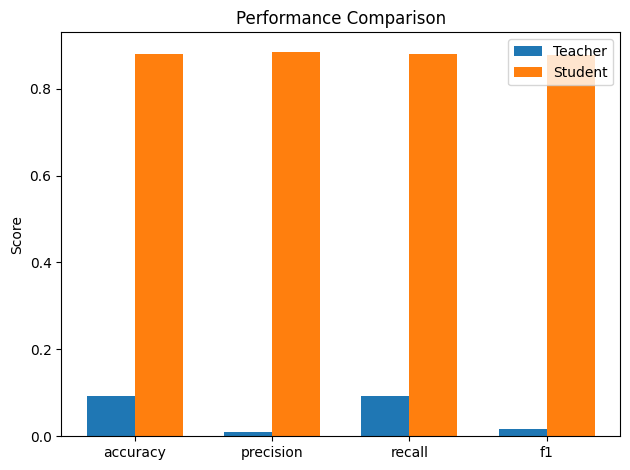

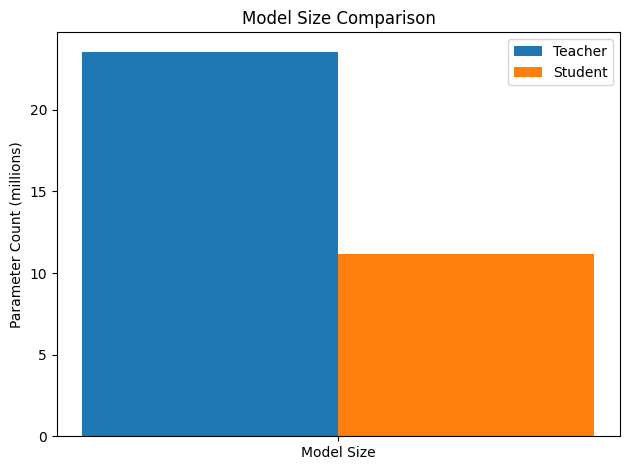

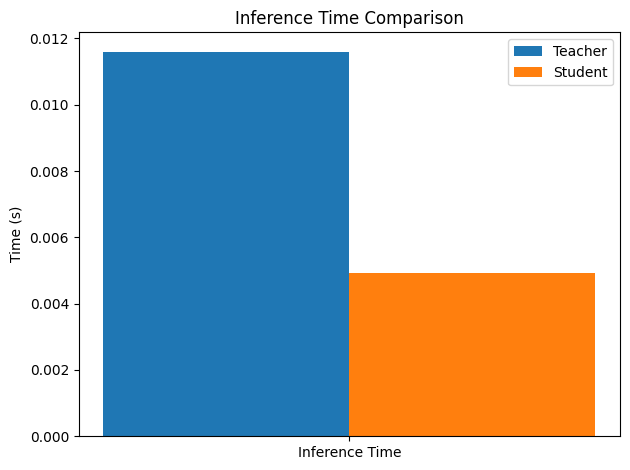

In [22]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)['metrics']
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]

student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

{'accuracy': (0.09221902017291066, 0.4040345821325648), 'precision': (0.008504347681651703, 0.41274801411558554), 'recall': (0.09221902017291066, 0.4040345821325648), 'f1': (0.015572604989620794, 0.39281734064573404)}


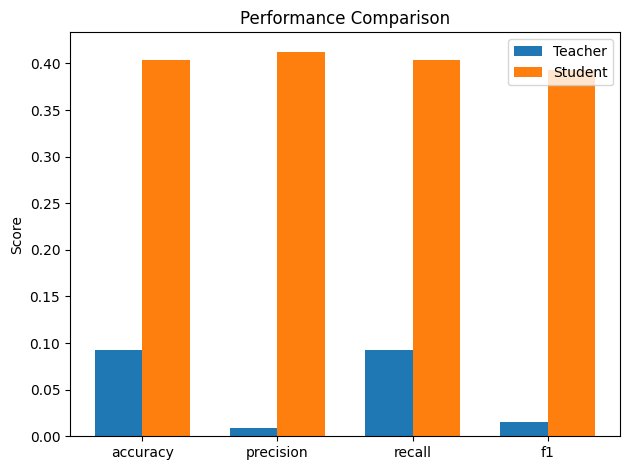

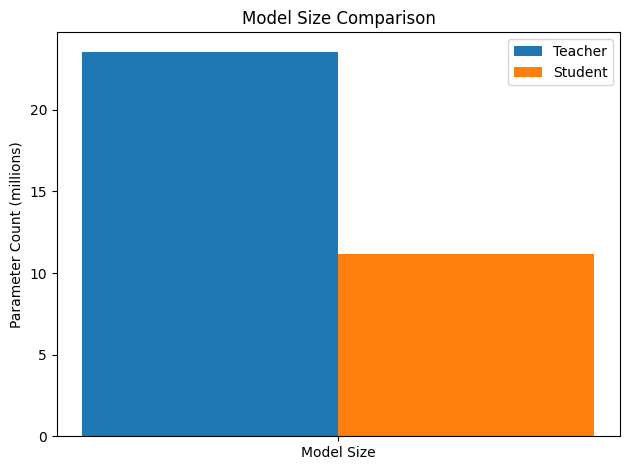

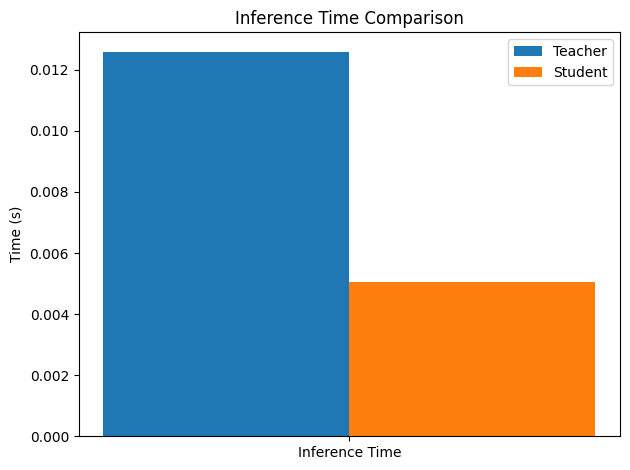

In [23]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)['metrics']
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]

student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')